In [124]:
import numpy
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams["figure.figsize"]=[6,6]

In [125]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

data=load_breast_cancer()
X, y=data.data, data.target

X=data.data[:,:4]
X_std=StandardScaler().fit_transform(X=X)
y=y.reshape(569,1)

In [126]:
#Keras por si mismo no se encarga de hacer todas las operaciones de bajo nivel (operaciones matriciales), sino que soporta varios backends (el motor que hara el entrenamiento), podemos elegir el que queramos activando la variable de entorno KERAS_BACKEND

#Keras soporta los siguientes backends

#theano: Libreria de deep learning original de python para deep learning. Hoy en dia raramente se usa por si sola
#tensorflow: Libreria de deep learning desarrollada por google
#CNTK: Libreria de deep learning desarrollada por Microsoft


In [127]:
#Antes de importar keras, modificar la variable de entorno de keras

In [128]:
import os
os.environ["KERAS_BACKEND"]="theano"

In [129]:
#Esta red neuronal se implementa facilmente com keras, usando la clase Sequential, que es similar a la clase RedNeuronal que se implemento a mano. Simplemente admite un conjunto de capas

In [130]:
from keras.models import Sequential
from keras.layers import Dense

modelo=Sequential()

modelo.add(Dense(units=5, activation="sigmoid", input_shape=(4,)))
modelo.add(Dense(units=1, activation="sigmoid"))

In [131]:
#Alternativamente podemos crear el modelo con las capas directamente

In [132]:
modelo=Sequential([
    Dense(units=5, activation="sigmoid", input_dim=4),
    Dense(units=1, activation="sigmoid")
])

In [133]:
#Ahora solo queda compilar el modelo y ya quedara preparado para entrenar. A la hora de compilar tenemos que definir la funcion de perdidas que medira el error propagado
#Keras tambien nos permite especificar metriccas que calculara para cada batch de entrenamiento y nos las dara como un historial despues de entrenar
#Podremos añadir el optimizador como string si queremos usarlo con sus hiperparametros por defecto (es decir, no queremos modificar su ratio de aprendizaje o cualquier otro hiperparametro)

In [134]:
modelo.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [135]:
#Si queremos modificar los parametros del optimizador tenemos que crear el objeto optimizador. Keras soporta SGD pero tambien muchos otros

In [136]:
from keras.optimizers import SGD
sgd=SGD(learning_rate=0.01)

In [137]:
modelo.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

In [138]:
modelo.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 5)                 25        
_________________________________________________________________
dense_113 (Dense)            (None, 1)                 6         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [139]:
#Vemos que tiene 31 parametros para entrenar, esto se corrresponde con los pesos de la red 
#(4*5 +5bias + 5x1 +1= 31 pesos)

In [140]:
#Ahora podemos ajustar el modelo a los datos de entrenamiento con el metodo fit. Es importante notar que por defecto keras hace mini batch, es decir, no entrena con observaciones individuales, sino grupos de observaciones (definido el tamaño de los grupos con el parametro batch_size)

In [141]:
historial=modelo.fit(x=X_std, y=y, epochs=100, verbose=0)

In [142]:
#Podemos ver la evolucion del funcionamiento del modelo desde el historial de entrenamiento

In [143]:
#historial.history

Text(0.5, 1.0, 'Precision vs epocas de entrenamiento')

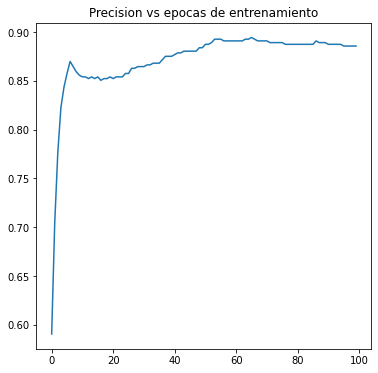

In [144]:
plt.plot(historial.history["accuracy"])
plt.title("Precision vs epocas de entrenamiento")

In [145]:
#Ahora se puede usar el metodo predict como si fuese un estimador de scikit-learn

In [146]:
modelo.predict(X_std)[:5]

array([[0.30512863],
       [0.0978238 ],
       [0.10326579],
       [0.8776499 ],
       [0.11450636]], dtype=float32)

In [147]:
#O si queremos predecir las clases directamente podemos usar predict_classes

In [148]:
modelo.predict_classes(X_std)[:5]

C:\Users\xmax1\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0],
       [0],
       [0],
       [1],
       [0]])

In [149]:
#Podemos evaluar el funcionamiento del modelo usando evaluate

In [150]:
scores=modelo.evaluate(X_std, y)
scores

18/18 [==============================] - 0s 1ms/step - loss: 0.3057 - accuracy: 0.8858


[0.30565983057022095, 0.885764479637146]

In [151]:
modelo.metrics_names

['loss', 'accuracy']

In [152]:
#Callbacks 

#son funciones que podemos hacer que se ejecuten en cada paso del proceso de entrenamiento

#Basicamente son clases que heredan de keras.callbacks.callback, con los siguientes metodos disponibles

#on_train_begin(): se ejecuta al iniciar el entrenamiento
#on_batch_befgin: se ejecuta al empezar el entrenamiento de un batch (mini batch)
#on_batch_end(): se ejecuta al acabar un batch (mini batch)
#on_epoch_begin(): se ejecuta al empezar una epoca de entrenamiento
#on_epoch_end(): se ejecuta al acabar una epoca de entrenamiento

In [153]:
#Por ejemplo, keras calcula las metricas en cada batch, supongamos que queremos calcular una metrica por epoca (que es mas representantivo que hacerlo en un batch)

In [154]:
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)



class MetricasEpoca(Callback):
    def on_train_begin(self, logs={}):
        self.f1_epoca=[]
        self.recall_epoca=[]
        self.precision_epoca=[]

    def __init__(self, val_data):
        super().__init__()
        self.validation_data = val_data

    def on_epoch_end(self, epoch, logs={}):
        val_predict=self.model.predict_classes(self.validation_data[0])
        val_targ=self.validation_data[1]

        f1=f1_score(val_targ, val_predict)
        recall=recall_score(val_targ, val_predict)
        precision=precision_score(val_targ, val_predict)
        self.f1_epoca.append(f1)
        self.recall_epoca.append(recall)
        self.precision_epoca.append(precision)

modelo=Sequential([
    Dense(units=5, activation="sigmoid", input_dim=4),
    Dense(units=1, activation="sigmoid")
])
modelo.compile(loss="binary_crossentropy", optimizer=sgd)

metricas_epoca=MetricasEpoca((X_std,y))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    modelo.fit(X_std, y, validation_data=(X_std, y),verbose=1,epochs=50,callbacks=[metricas_epoca])

Epoch 1/50
18/18 [==============================] - 1s 20ms/step - loss: 0.6232 - val_loss: 0.6143
Epoch 2/50
18/18 [==============================] - 0s 9ms/step - loss: 0.6210 - val_loss: 0.6039
Epoch 3/50
18/18 [==============================] - 0s 7ms/step - loss: 0.5917 - val_loss: 0.5948
Epoch 4/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5936 - val_loss: 0.5867
Epoch 5/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5824 - val_loss: 0.5794
Epoch 6/50
18/18 [==============================] - 0s 10ms/step - loss: 0.5700 - val_loss: 0.5728
Epoch 7/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5802 - val_loss: 0.5668
Epoch 8/50
18/18 [==============================] - 0s 9ms/step - loss: 0.5736 - val_loss: 0.5611
Epoch 9/50
18/18 [==============================] - 0s 7ms/step - loss: 0.5574 - val_loss: 0.5558
Epoch 10/50
18/18 [==============================] - 0s 9ms/step - loss: 0.5502 - val_loss: 0.5509
Epoch 11/50
18/18

Text(0.5, 1.0, 'Metrica F1 vs numero de epocas')

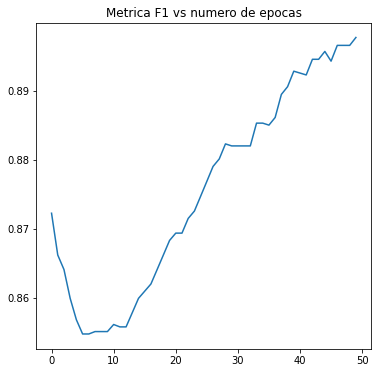

In [155]:
plt.plot(metricas_epoca.f1_epoca)
plt.title("Metrica F1 vs numero de epocas")

In [156]:
#Early Stopping
#El entrenamiento de un modelo de deep learning es iterativo, esto significa que en teoria podemos dejar el modelo aprendiendo independientemente. En el caso de usar descenso estocastico de gradiente (SGD) para aprender, el error simplemente continuara dando vueltas alrededor del minimo error

#Para evitar que entrenar durante el numero definido de epocas si el modelo ya ha convergido antes a lminimo error, podemos implementar lo que se llama early stopping. Basicamente, esto para el entrenamiento cuando se cumpen ciertas condiciones

In [157]:
from keras.callbacks import EarlyStopping

In [158]:
#Los parametros principales del EarlyStopping son los siguientes

#monitor: La metrica a monitorizar
#min_delta: La minima cantidad de variacion entre epocas de la metrica para considerarlo un progreso (y continuar entrenando)
#Patience: numero de epocas sin mejora despues de las cuales se para el entrenamiento

In [159]:
earlystop=EarlyStopping(
    monitor="acc",
    min_delta=0.000001, 
    patience=10,
    verbose=1,
    mode="auto"
)

modelo=Sequential([
    Dense(units=5, activation="sigmoid", input_dim=4),
    Dense(units=1, activation="sigmoid")
])

modelo.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["acc"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    modelo.fit(X_std, y, epochs=50, verbose=1, callbacks=[earlystop])

Epoch 1/50
18/18 [==============================] - 1s 2ms/step - loss: 0.7163 - acc: 0.3615
Epoch 2/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6963 - acc: 0.4316
Epoch 3/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6778 - acc: 0.7210
Epoch 4/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6586 - acc: 0.7509
Epoch 5/50
18/18 [==============================] - 0s 1ms/step - loss: 0.6457 - acc: 0.7327
Epoch 6/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6339 - acc: 0.7476
Epoch 7/50
18/18 [==============================] - 0s 3ms/step - loss: 0.6191 - acc: 0.7377
Epoch 8/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6149 - acc: 0.7115
Epoch 9/50
18/18 [==============================] - 0s 1ms/step - loss: 0.6028 - acc: 0.7418
Epoch 10/50
18/18 [==============================] - 0s 1ms/step - loss: 0.5875 - acc: 0.7605
Epoch 11/50
18/18 [==============================] - 0s 1ms/step - lo

In [160]:
#Guardado de modelos en Keras

#En Keras, podemos guardar un modelo (de forma similar a como haciamos con joblib/pickie en scikit-learn) tanto durante el proceso de entrenamiento (checkpoints) como al acabar el entrenamiento

In [161]:
from keras.callbacks import ModelCheckpoint

In [162]:
checkpoint=ModelCheckpoint(filepath="modelo.hdf5", verbose=1, save_freq=100)

modelo=Sequential([
    Dense(units=5, activation="sigmoid", input_dim=4),
    Dense(units=1, activation="sigmoid")
])

modelo.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["acc"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    modelo.fit(X_std, y, epochs=50, verbose=1, callbacks=[checkpoint])


Epoch 1/50
18/18 [==============================] - 1s 2ms/step - loss: 0.7620 - acc: 0.1144
Epoch 2/50
18/18 [==============================] - 0s 2ms/step - loss: 0.7477 - acc: 0.1446
Epoch 3/50
18/18 [==============================] - 0s 2ms/step - loss: 0.7299 - acc: 0.3257
Epoch 4/50
18/18 [==============================] - 0s 3ms/step - loss: 0.7209 - acc: 0.5144
Epoch 5/50
18/18 [==============================] - 0s 2ms/step - loss: 0.7159 - acc: 0.5726
Epoch 6/50
 1/18 [>.............................] - ETA: 0s - loss: 0.7048 - acc: 0.6250
Epoch 00006: saving model to modelo.hdf5
18/18 [==============================] - 0s 4ms/step - loss: 0.6969 - acc: 0.6392
Epoch 7/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6933 - acc: 0.6168
Epoch 8/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6876 - acc: 0.6153
Epoch 9/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6814 - acc: 0.6115
Epoch 10/50
18/18 [=========================

In [163]:
#Guardado de modelos en keras
#En Keras, podemos guardar un modelo (de forma similar a como haciamos con jobliib/pickie en scikit-learn) tanto durante el proceso de entrenamiento, como al acabar el entrenamiento

In [164]:
modelo.save

<bound method Model.save of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002C8A8B35808>>

In [165]:
#Cargar modelo

In [166]:
from keras.models import load_model

In [167]:
modelo_recargado=load_model("modelo.hdf5")

In [168]:
modelo_recargado.predict(X_std)[:5]

array([[0.52744573],
       [0.4768132 ],
       [0.4819057 ],
       [0.71414244],
       [0.4780311 ]], dtype=float32)

In [169]:
#Validacion Cruzada
#Podemos crear Redes en Keras de forma que sean compatibles con Scikit-learn

#En Deep Learning, en general no se suele hacer validacion cruzada a menos que el dataset sea pequeño, ya que los tiempos de entrenamiento de modelos y los datasets suelen ser bastante elevado. No obstante si podemos permitirnoslo es aconsejable

In [170]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

def generar_modelo():
    modelo=Sequential()
    modelo.add(Dense(units=5, activation="sigmoid", input_dim=4))
    modelo.add(Dense(units=1, activation="sigmoid"))
    sgd=SGD(learning_rate=0.01)
    modelo.compile(loss="binary_crossentropy",
    optimizer=sgd,
    metrics=["accuracy"])
    return modelo

kfold=RepeatedStratifiedKFold(n_repeats=5)
cvscores=[]
for train, test in kfold.split(X_std, y):
    modelo=generar_modelo()
    modelo.fit(X_std[train], y[train], epochs=50, verbose=0)
    scores=modelo.evaluate(X_std[test], y[test], verbose=0)
    cvscores.append(scores[1])

In [171]:
numpy.mean(cvscores)

0.8083806824684143

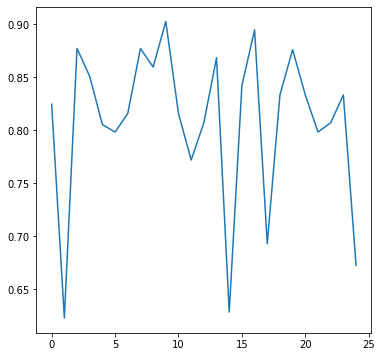

In [172]:
plt.plot(cvscores)

In [173]:
#Optimizacion de hiperparametros

In [188]:
from keras.wrappers.scikit_learn import KerasClassifier

def generar_modelo(n_oculta=5, activacion="sigmoid"):
    modelo=Sequential()
    modelo.add(Dense(units=5, activation=activacion, input_dim=4))
    modelo.add(Dense(units=1, activation="sigmoid"))
    sgd=SGD(learning_rate=0.001)
    modelo.compile(loss="binary_crossentropy",
    optimizer=sgd,
    metrics=["accuracy"])
    return modelo

modelo=KerasClassifier(build_fn=generar_modelo, verbose=0)

In [189]:
#Tambien vamos a añaddir una variable de entorno para controlar como funciona la busqueda de malla. Generalmente pasamos el argumento n_jobs=-1, que le indica a sklearn que puede usar todos los nucleos de nuestro ordenador 
#Esto puede dar problemas al ejecutar el codigo desde un jupyter notebook

In [190]:
#os.environ["JOBLIB_START_METHOD"]="forkserver" #solo si falla 

In [191]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_grid={
    "epochs": [10,30],
    "n_oculta": [5,20],
    "activacion":("sigmoid", "relu")    
}

grid=GridSearchCV(estimator=modelo, param_grid=param_grid, scoring="accuracy")

In [192]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    grid_result=grid.fit(X_std,y)

stype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\xmax1\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\xmax1\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.a

In [193]:
print("Mejor estimador (error {:.5f}): {}".format(grid_result.best_score_, grid_result.best_params_))

Mejor estimador (error 0.71039): {'activacion': 'sigmoid', 'epochs': 10, 'n_oculta': 20}
